[*********************100%%**********************]  1 of 1 completed

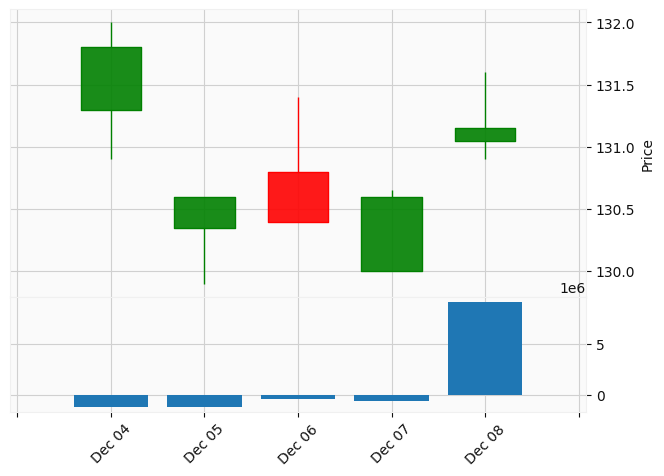

In [9]:
# 載入必要套件
from BackTest import ChartTrade
import mplfinance as mpf
import pandas as pd
import os
import yfinance as yf


# 設定在根目錄即可，之後可以改到 /data
datapath = "./"

# 更新資料源為 yahoo finance
def getDataFM(prod, st, en):
    #
    bakfile = f"data//YF_{prod}_{st}_{en}_stock_daily_adj.csv"
    if os.path.exists(bakfile):
        data = pd.read_csv(bakfile)
        data["Date"] = pd.to_datetime(data["Date"])
        data = data.set_index("Date")
    else:
        data = yf.download(f"{prod}.TW", start=st, end=en)
        data.columns = [i.lower() for i in data.columns]
        # 除錯 如果沒有資料
        if data.shape[0] == 0:
            print("沒有資料")
            return pd.DataFrame()
        # 將資料寫入備份檔
        data.to_csv(bakfile)
    return data


# 取得三大法人 證交所資料來源
def getTSEInstitutionalInvestors(prod, st, en):
    # 備份檔名
    bakfile = f"{datapath}//{prod}_{st}_{en}_TSE_InstitutionalInvestorsBuySell.csv"
    # 檢視是否有該檔案存在
    if os.path.exists(bakfile):
        # 取得檔案內容
        tmpdata = pd.read_csv(bakfile)
        tmpdata["日期"] = pd.to_datetime(tmpdata["日期"])
        tmpdata = tmpdata.set_index(tmpdata["日期"])
        tmpdata.drop("日期", axis=1, inplace=True)

    # 沒有的話就取檔案內容
    else:
        # 取得檔案內容
        tmpdata = pd.read_csv("三大法人爬蟲資料.csv", encoding="utf-8")
        tmpdata = tmpdata[
            (tmpdata["證券代號"] == prod) &
            (tmpdata["日期"] >= int(st)) &
            (tmpdata["日期"] <= int(en))
        ]
        tmpdata["日期"] = pd.to_datetime(tmpdata["日期"], format="%Y%m%d")
        tmpdata = tmpdata.set_index(tmpdata["日期"])
        tmpdata.drop("日期", axis=1, inplace=True)
        # 將資料內容轉換為數值
        for i in range(2, tmpdata.shape[1]):
            tmpdata.iloc[:, i] = tmpdata.iloc[:, i].str.replace(",", "")
            tmpdata.iloc[:, i].astype(int)
        # 將單一證券內容寫入備份檔中
        tmpdata.to_csv(bakfile)
    # 回傳資料
    return tmpdata


# 取得K線與三大法人的集合資料 透過 證交所
def getPriceAndInstInvest_TSE(prod, st, en):
    # 取得還原股價
    data1 = getDataFM(prod, st, en)
    # 取得證交所的三大法人
    st = st.replace("-", "")
    en = en.replace("-", "")
    data2 = getTSEInstitutionalInvestors(prod, st, en)
    data3 = pd.concat([data1, data2], axis=1, join="inner")
    return data3


# 取得回測資料
prod = "0050"
data = getPriceAndInstInvest_TSE(prod, "2023-12-01", "2023-12-10")

# 先將這兩列轉換為數值類型
data["外陸資買進股數(不含外資自營商)"] = pd.to_numeric(data["外陸資買進股數(不含外資自營商)"], errors='coerce')
data["外陸資賣出股數(不含外資自營商)"] = pd.to_numeric(data["外陸資賣出股數(不含外資自營商)"], errors='coerce')
# 計算 外資平均買賣
data["F_day"] = data["外陸資買進股數(不含外資自營商)"] - data["外陸資賣出股數(不含外資自營商)"]
data["F_month"] = (data["F_day"]).rolling(20).sum()
data["F_mean"] = (data["F_month"]).rolling(40).mean()

# 繪製副圖
addp = []
# 外資買賣力道
addp.append(mpf.make_addplot(data["F_day"], panel=1, type="bar", secondary_y=False))
addp.append(mpf.make_addplot(data["F_month"], panel=1, color="red", secondary_y=False))
addp.append(mpf.make_addplot(data["F_mean"], panel=1, color="blue", secondary_y=False))

# 繪製K線圖與交易明細
ChartTrade(data, addp=addp, v_enable=False)
